# Satellite Surface Radiation Budget intercomparison for climate change monitoring

Production date: 29-06-2023

Produced by: CNR-ISMAR, Andrea Storto and Vincenzo de Toma

## 🌍 Use case: Use surface radiation budget to monitor climate change

## ❓ Quality assessment question(s)
* **What is the climatology and temporal variability of SRB and its uncertainty? Can I use it to monitor the change in the radiation budget?**

**‘Context’** The Surface Radiation Budget (SRB) products allow quantifying the surface energy budget, the energy exchanges at the atmospheric lower boundary (with ocean, ice, and land), and their temporal and spatial variability, for use in several climate applications. Their temporal coverage and spatial detail vary significantly between the products. There exist offsets between the product, which tend to be significant near the polar regions for shortwave components, and at low latitudes for longwave fluxes.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* The surface radiation budget (SRB) products capture the spatial and temporal variability of the radiative fluxes at the surface, for use in climate analyses, energy budget studies, and climate model assessment
* The SRB products have different temporal coverage and spatial resolution, namely their combined use is not straightforward and it is recommended for advanced users only, or within selected periods
* The consistency between the products concerning spatially averaged values is sufficient, although systematic offsets occur between the products, especially for the longwave (downwelling and outgoing) products
* Climatological maps and zonally averaged values indicate that the products suffer from poor consistency in some areas, e.g. longwave flux components (downwelling and outgoing) at low latitudes, and shortwave at high latitudes. 
```

Using satellite data to estimate the surface radiation budget - comprising shortwave and longwave radiation at the interfaces between atmosphere and ocean, atmosphere and land, and atmosphere and ice - is often discontinuous and poses significant challenges for climate monitoring and model verification. These estimates can be influenced by various atmospheric conditions and instrument limitations, making their use complex and recommended only for expert users ([[1]](https://doi.org/10.1016/j.agrformet.2006.02.001); [[2]](https://doi.org/10.1175/2008BAMS2634.1)). Partial temporal (and spatial, to a lesser extent) sampling of the datasets hampers their easy utilization.

```{figure} attachment:955600f0-e8db-4f87-b515-9c9c8689440d.png
Zonally averaged outgoing longwave radiation at the surface
```
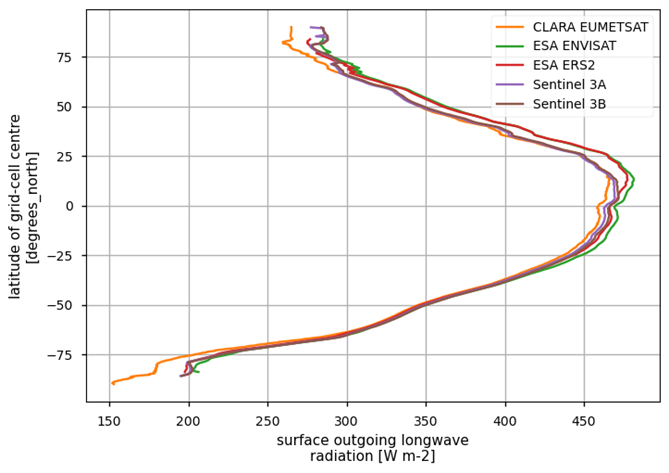

## 📋 Methodology

In this notebook we inter-compare the following catalogue entries from the Climate and Atmosphere Data Store (CDS) by Copernicus:

1. CLARA-A2: CM SAF cLoud, Albedo and surface RAdiation dataset from AVHRR data - Edition 2. Satellite Application Facility on Climate Monitoring (CLARA EUMETSAT)
2. ESA Cloud Climate Change Initiative (ESA Cloud_cci) data: Cloud_cci ATSR2-AATSR L3C/L3U CLD_PRODUCTS v3.0.
3. Surface Radiation Budget, CCI ICDR product version 3.1. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). (CLARA C3S)
In particular, this analysis takes into account the Essential Climate Variables (ECV) as follows:

- Surface Reflected Solar Radiation (SRS);
- Surface Incoming Solar Radiation (SIS);
- Surface Downwelling Longwave Radiation (SDL);
- Surface Outgoing Longwave Radiation (SOL).

The analysis and results are organised in the following steps, which are detailed in the sections below:

**1. [Choose the data to use and setup code](choose-the-data-to-use-and-setup-code):**

**2. [Download and Transform](download-and-transform):**

**3. [Plot Spatial weighted time series, Time weighted means, Spatial weighted Zonal means](plot-spatial-weighted-time-series-time-weighted-means-spatial-weighted-zonal-means):**
 * Plot Spatial weighted time series
 * Time weighted means
 * Spatial weighted Zonal means

## 📈 Analysis and results

(choose-the-data-to-use-and-setup-code)=
### 1. Choose the data to use and setup code

In this section, we import the required packages and set up the dataset names for further use in the following sections. Processing functions are also defined. 

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

# Variables to analyse
variables = ("srs", "sis", "sdl", "sol")

collection_id = "satellite-surface-radiation-budget"
chunks = {"year": 1}
request_dict = {
    "CLARA C3S": {
        "start": "2016-01",
        "stop": "2017-12",
        "climate_data_record_type": "thematic_climate_data_record",
        "format": "zip",
        "origin": "c3s",
        "product_family": "clara_a2",
        "time_aggregation": "monthly_mean",
        "variable": "surface_upwelling_shortwave_flux",
        "version": "v2_0_1",
    },
    "CLARA EUMETSAT": {
        "start": "2014-01",
        "stop": "2017-12",
        "climate_data_record_type": "thematic_climate_data_record",
        "format": "zip",
        "origin": "eumetsat",
        "product_family": "clara_a2",
        "time_aggregation": "monthly_mean",
        "variable": [
            "surface_downwelling_longwave_flux",
            "surface_downwelling_shortwave_flux",
            "surface_upwelling_longwave_flux",
        ],
        "version": "v2_0",
    },
    "ESA ENVISAT": {
        "start": "2007-01",
        "stop": "2010-12",
        "climate_data_record_type": "thematic_climate_data_record",
        "format": "zip",
        "origin": "esa",
        "product_family": "cci",
        "sensor_on_satellite": "aatsr_on_envisat",
        "time_aggregation": "monthly_mean",
        "variable": "all_variables",
    },
    "ESA ERS2": {
        "start": "2000-01",
        "stop": "2002-12",
        "climate_data_record_type": "thematic_climate_data_record",
        "format": "zip",
        "origin": "esa",
        "product_family": "cci",
        "sensor_on_satellite": "atsr2_on_ers2",
        "time_aggregation": "monthly_mean",
        "variable": "all_variables",
    },
    "Sentinel 3A": {
        "start": "2019-01",
        "stop": "2020-12",
        "climate_data_record_type": "interim_climate_data_record",
        "format": "zip",
        "origin": "c3s",
        "product_family": "cci",
        "sensor_on_satellite": "slstr_on_sentinel_3a",
        "time_aggregation": "monthly_mean",
        "variable": "all_variables",
    },
    "Sentinel 3B": {
        "start": "2019-01",
        "stop": "2020-12",
        "climate_data_record_type": "interim_climate_data_record",
        "format": "zip",
        "origin": "c3s",
        "product_family": "cci",
        "sensor_on_satellite": "slstr_on_sentinel_3b",
        "time_aggregation": "monthly_mean",
        "variable": "all_variables",
    },
}

# Functions to cache
def preprocess_time(ds):
    if "time" in ds and "units" in ds["time"].attrs:
        # Could not decode
        ds = ds.squeeze("time", drop=True)
    if "time" not in ds:
        time = pd.to_datetime(ds.attrs["time_coverage_start"])
        ds = ds.assign_coords(time=time)
    return ds


def spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return diagnostics.spatial_weighted_mean(ds)

xarray_kwargs = {"drop_variables": "time_bounds", "preprocess": preprocess_time}

(download-and-transform)=
### 2. Download and Transform

The code below will download the products.

In [2]:
ds_maps = {}
ds_timeseries = {}
for product, request in request_dict.items():
    print(f"{product}")
    start = request.pop("start")
    stop = request.pop("stop")
    requests = download.update_request_date(
        request, start=start, stop=stop, stringify_dates=True
    )

    # Maps
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=diagnostics.time_weighted_mean,
        chunks=chunks,
        transform_chunks=False,
        **xarray_kwargs,
    )
    ds.attrs.update({"start": start, "stop": stop})
    ds_maps[product] = ds.rename({var: var.lower() for var in ds.data_vars})

    # Timeseries
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=spatial_weighted_mean,
        transform_func_kwargs={
            "lon_slice": slice(-180, 180),
            "lat_slice": slice(-90, 90),
        },
        chunks=chunks,
        **xarray_kwargs,
    )
    ds_timeseries[product] = ds.rename({var: var.lower() for var in ds.data_vars})

CLARA C3S


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


CLARA EUMETSAT


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


ESA ENVISAT


100%|██████████| 4/4 [00:00<00:00, 12.72it/s]


ESA ERS2


100%|██████████| 3/3 [00:00<00:00, 13.04it/s]


Sentinel 3A


100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


Sentinel 3B


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


(plot-spatial-weighted-time-series-time-weighted-means-spatial-weighted-zonal-means)=
### 3. Plot Spatial weighted time series, Time weighted means, Spatial weighted Zonal means

#### Plot Spatial weighted time series
Below, we calculate and plot spatially weighted means for the different surface radiation budget products. Please note that masks of available data may differ across the products.

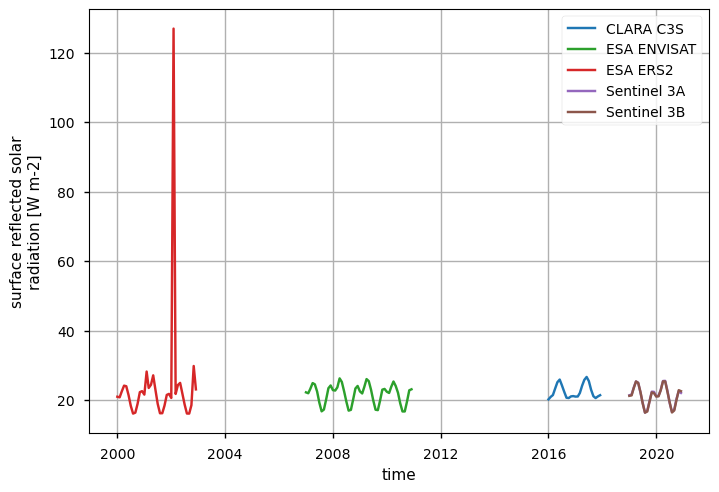

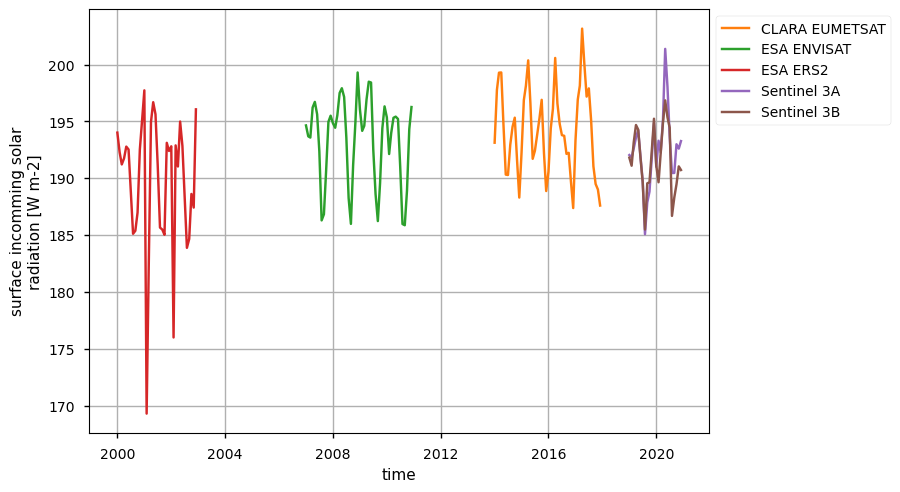

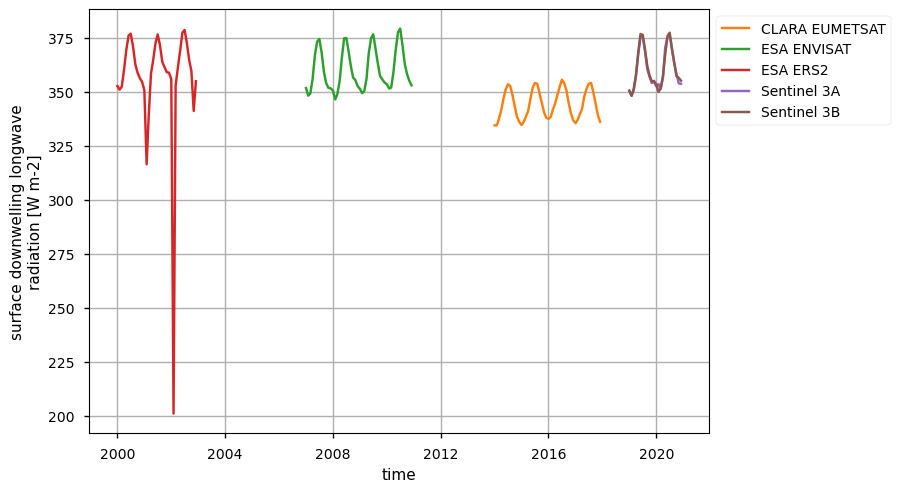

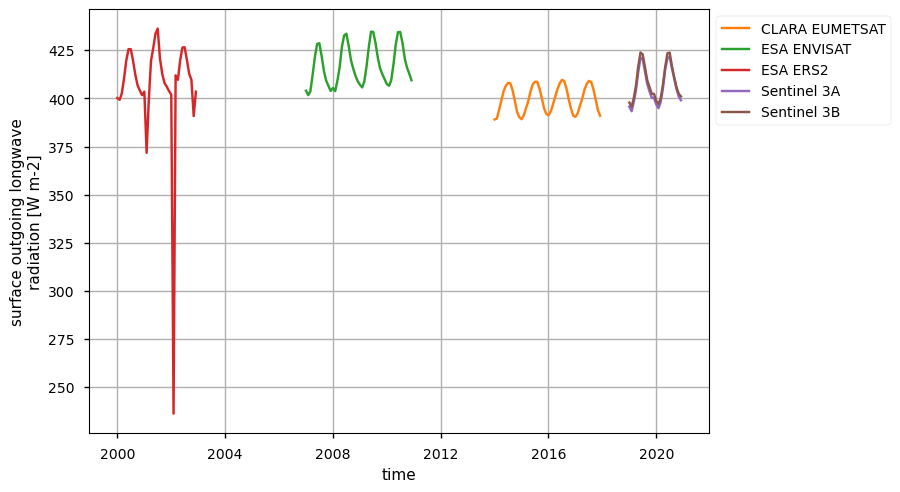

In [3]:
for var in variables:
    for i, (product, ds) in enumerate(ds_timeseries.items()):
        if var not in ds.data_vars:
            continue
        ds[var].plot(label=product, color=f"C{i}")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

The timeseries above show that the different products do not overlap temporally, and thus they can be combined for expert use only. Moreover, there exist significant offsets, especially for the surface (outgoing and downwelling) longwave radiation.

#### Plot Time weighted means
Below, we calculate and plot time-weighted means for the different surface radiation budget products. Please note that periods differ across the products as shown in the previous section.

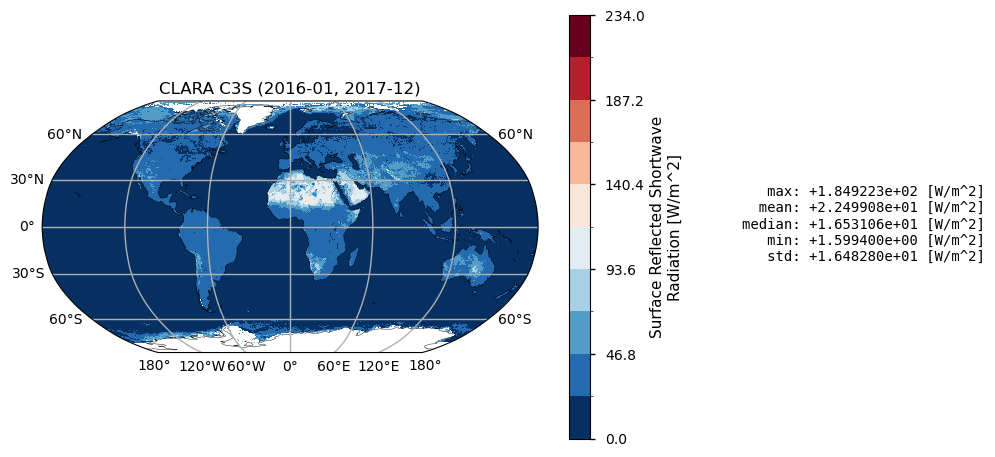

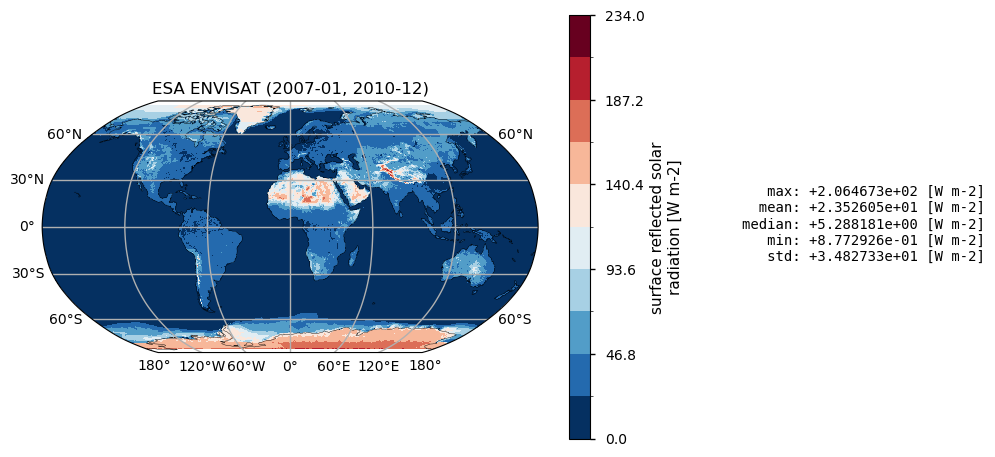

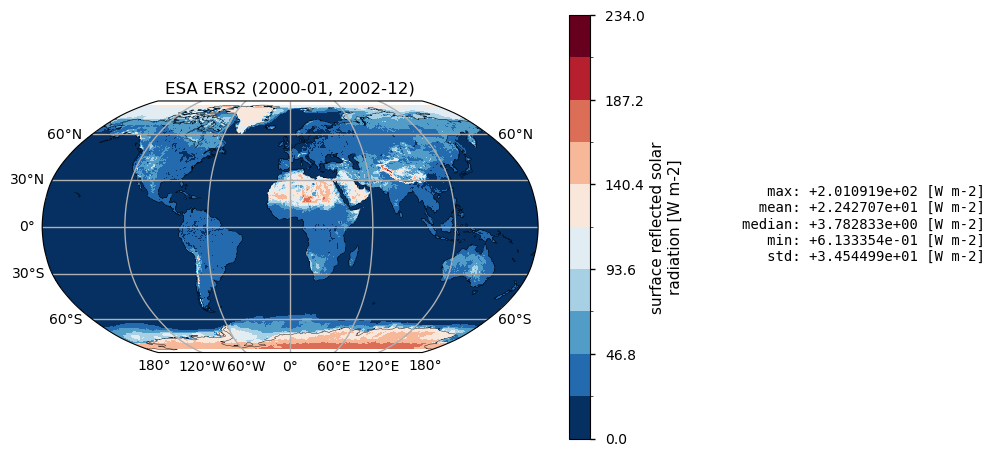

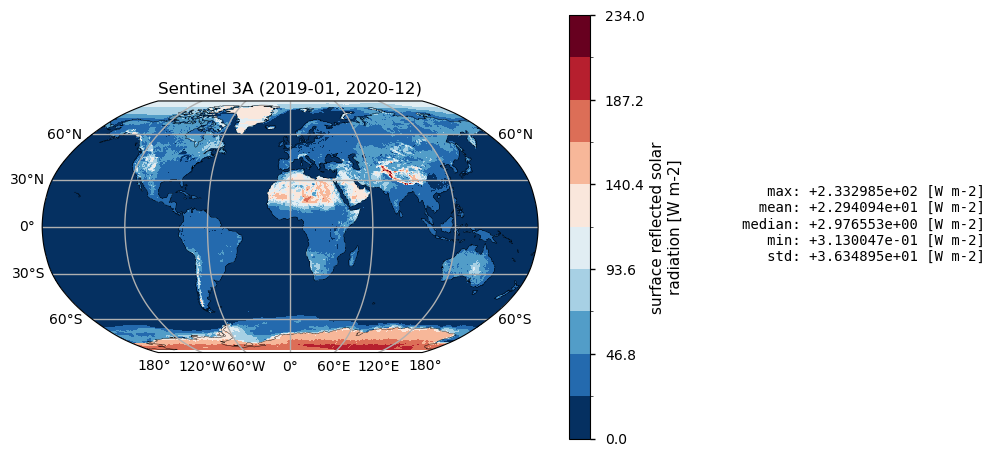

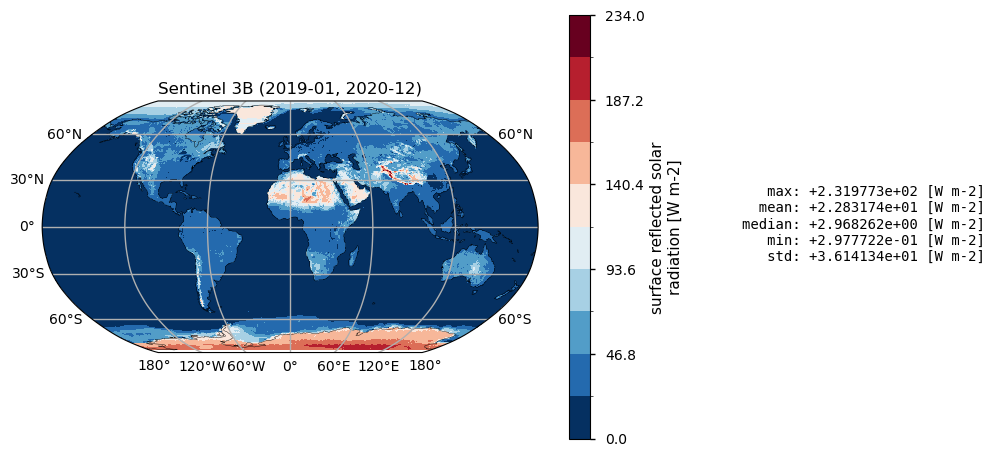

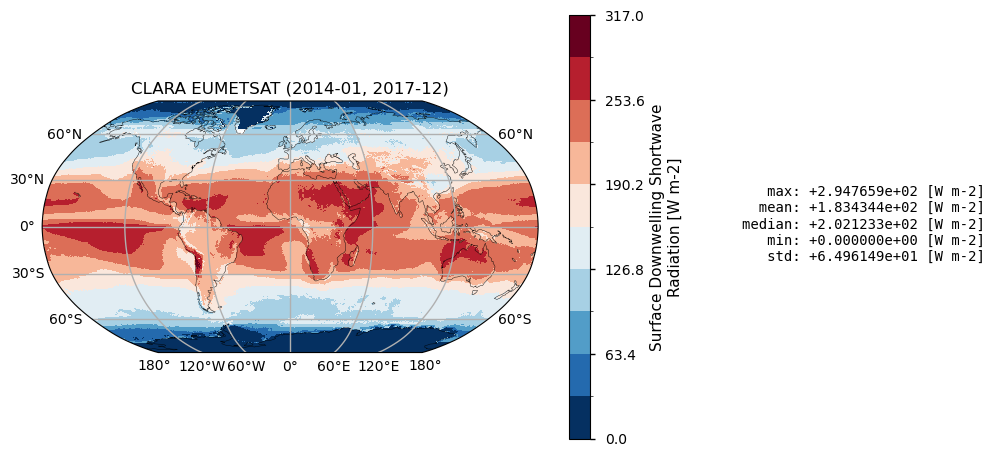

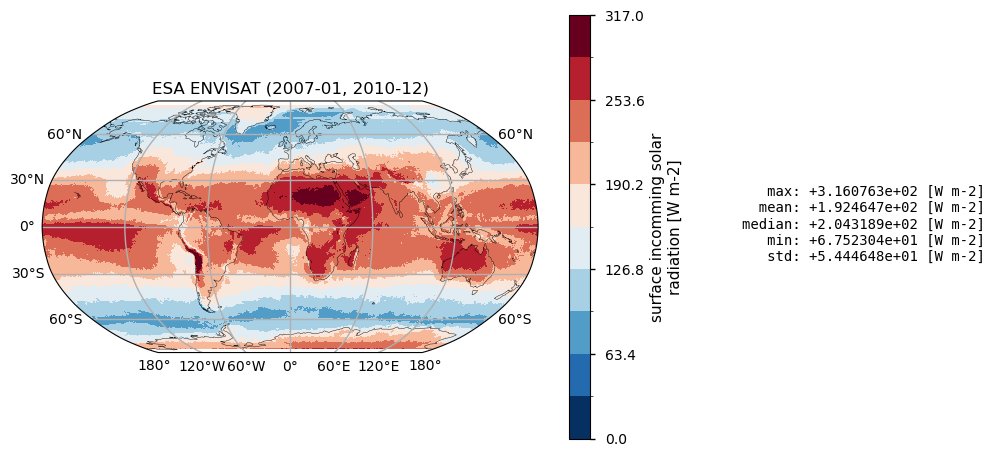

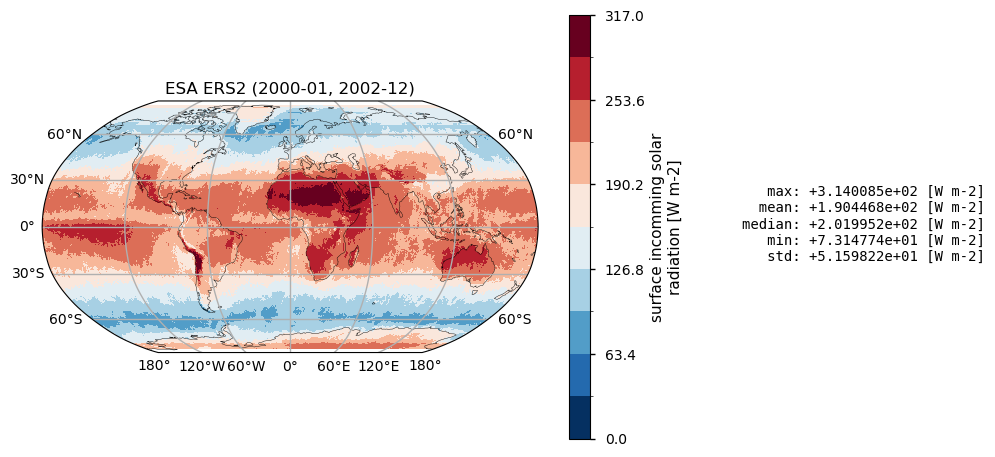

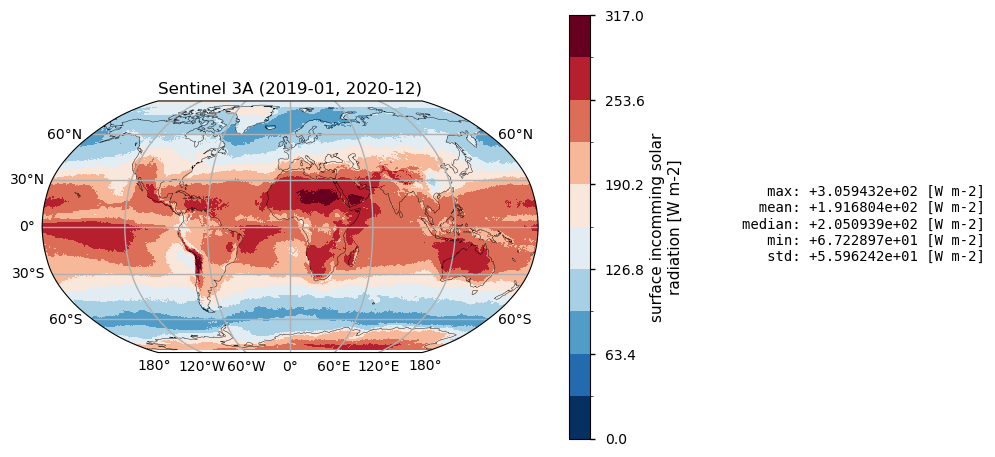

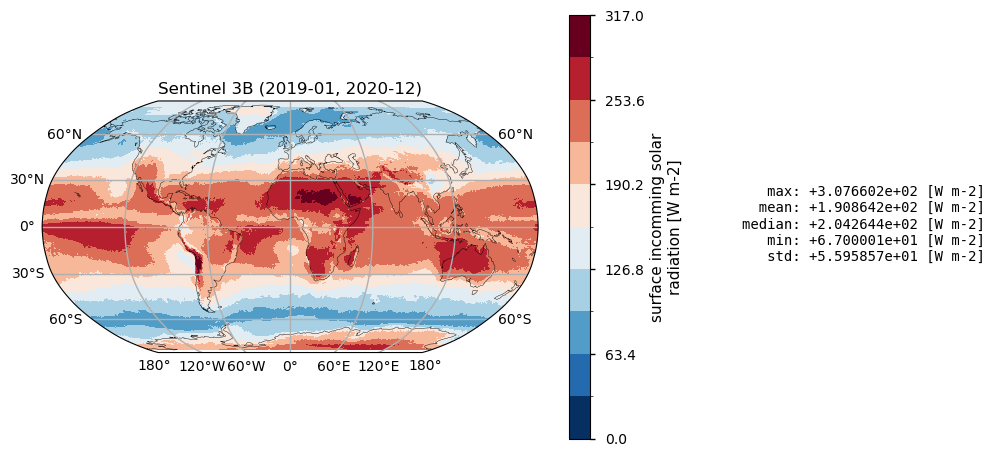

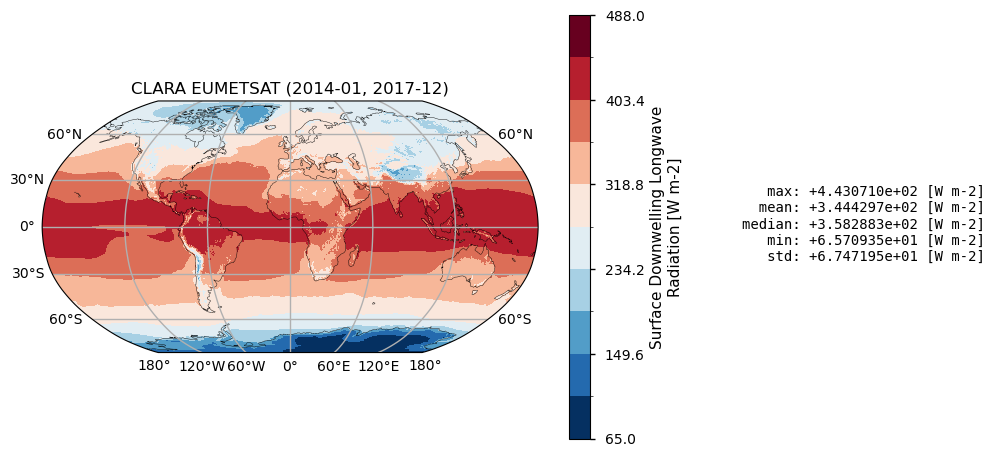

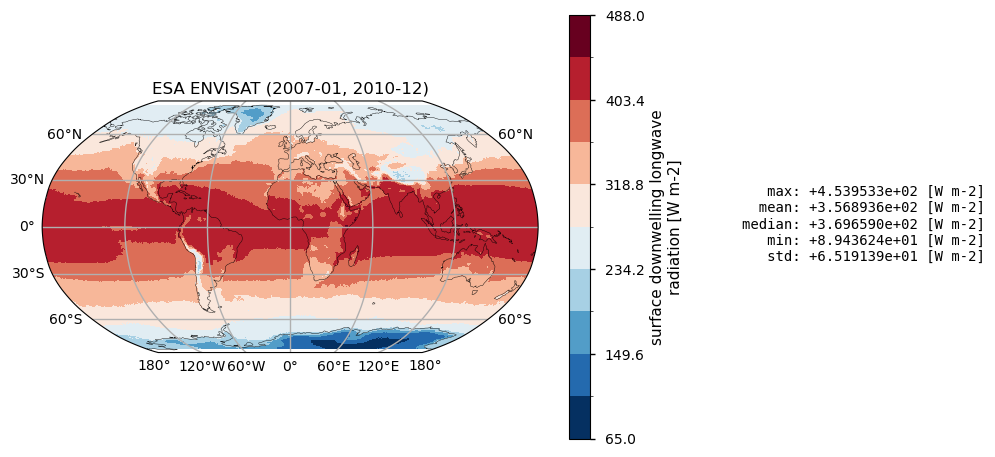

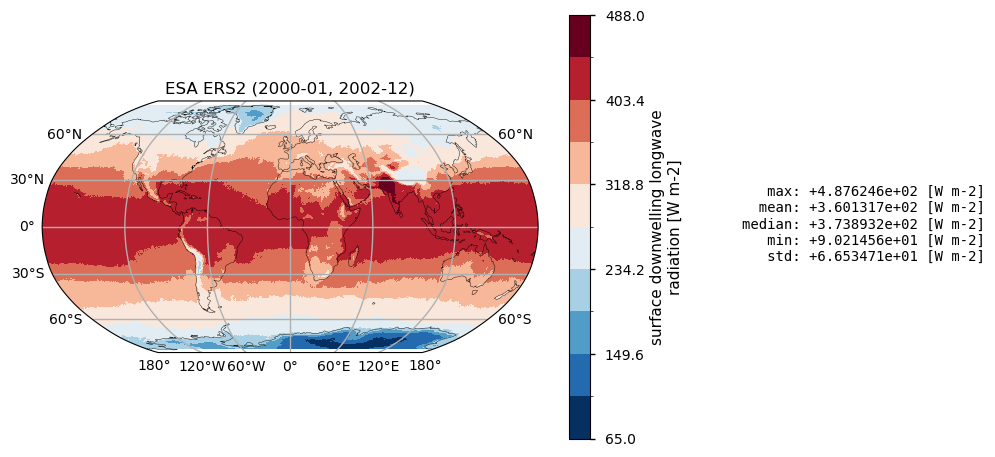

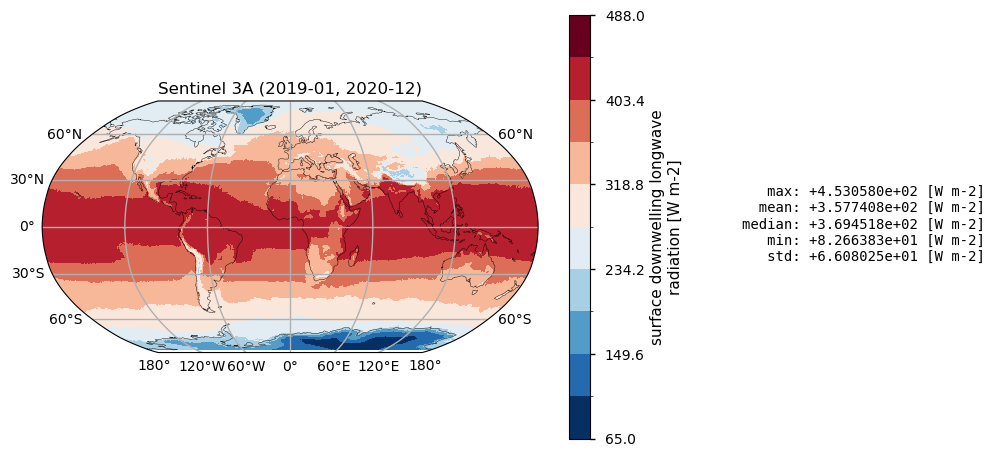

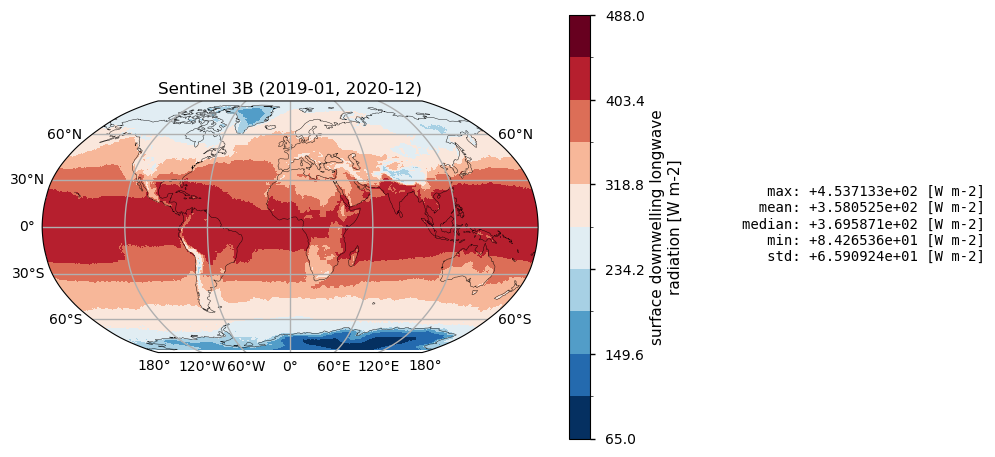

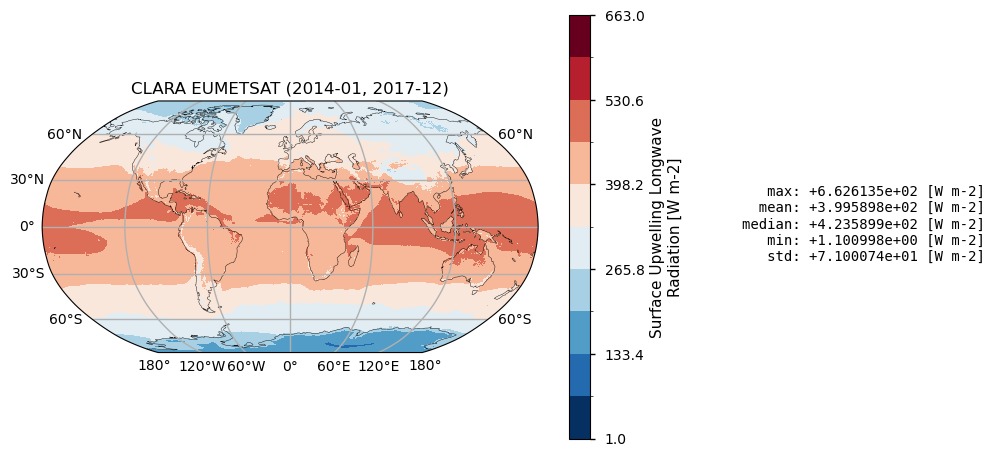

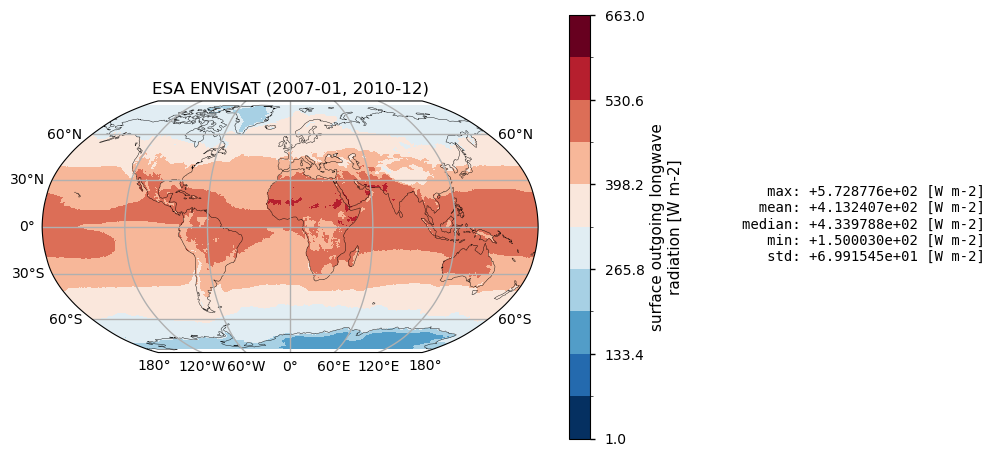

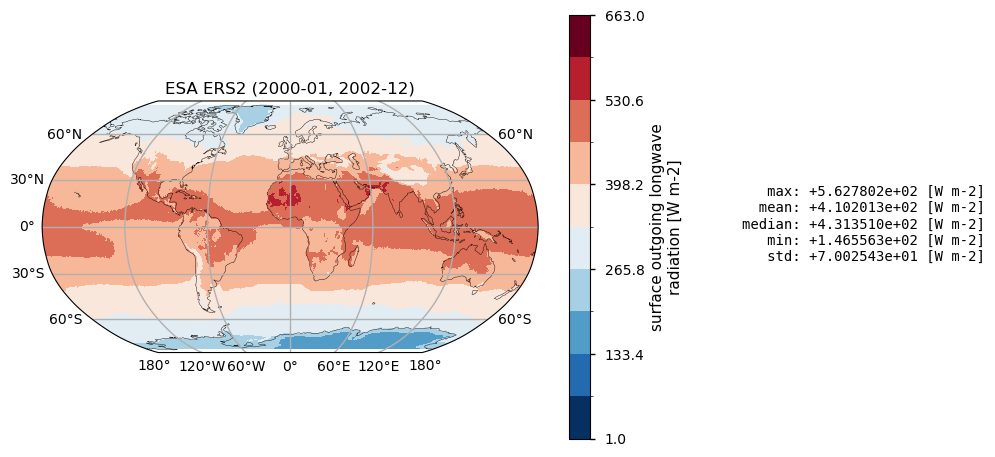

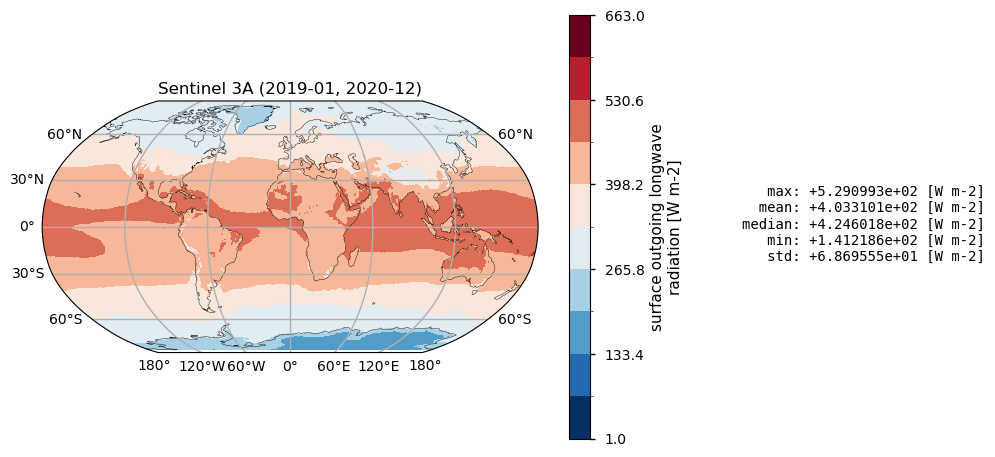

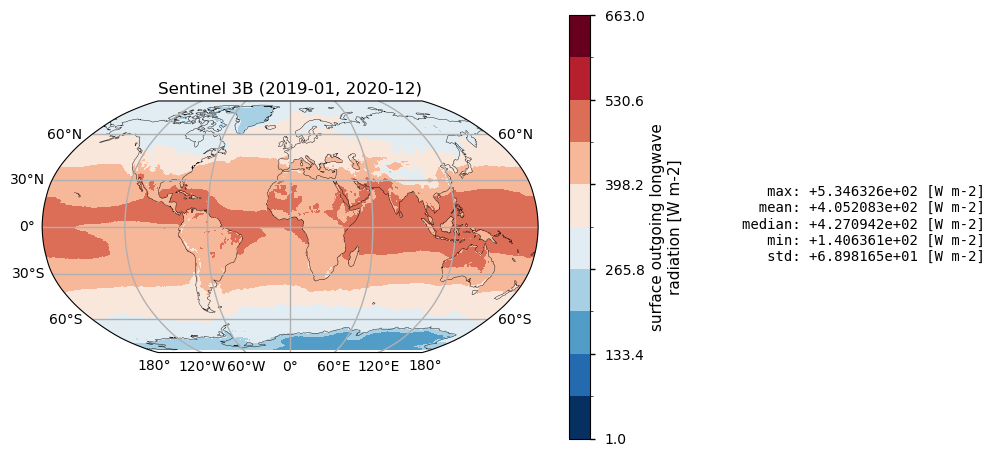

In [4]:
for var in variables:
    vmin = min([ds[var].min().values for ds in ds_maps.values() if var in ds.data_vars])
    vmax = max([ds[var].max().values for ds in ds_maps.values() if var in ds.data_vars])
    for product, ds in ds_maps.items():
        if var not in ds.data_vars:
            continue
        plot.projected_map(
            ds[var],
            projection=ccrs.Robinson(),
            levels=11,
            vmin=np.floor(vmin),
            vmax=np.ceil(vmax),
            cmap="RdBu_r",
        )
        plt.title(f"{product} ({ds.attrs['start']}, {ds.attrs['stop']})")
        plt.show()

Maps exhibit generally similar features, although the different products are poorly consistent in many areas, especially longwave flux components (downwelling and outgoing) at low latitudes, and shortwave at high latitudes.

#### Plot Spatial weighted Zonal means
The code below will calculate and plot weighted zonal means for the surface radiation budget products. Please note that spatial and temporal sampling may differ across the products.

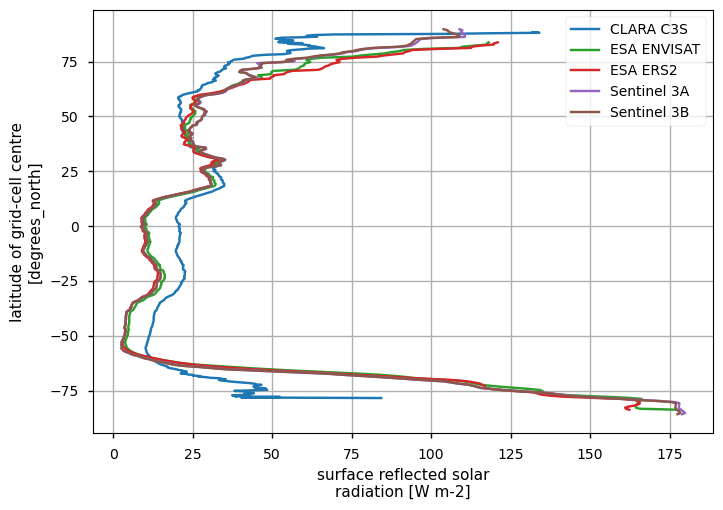

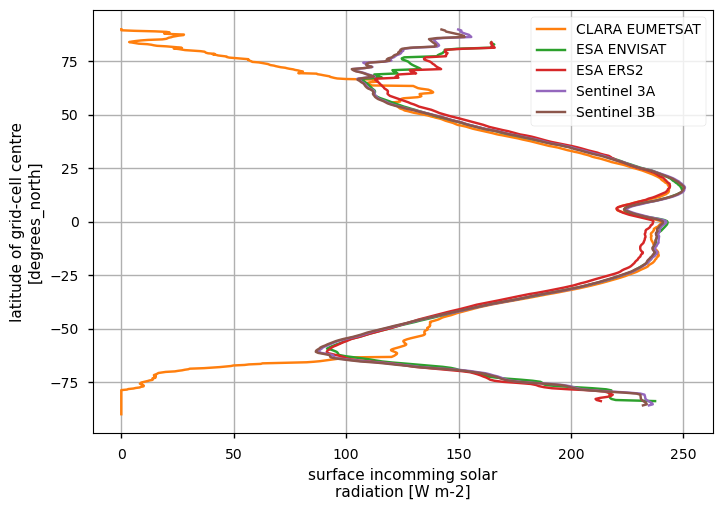

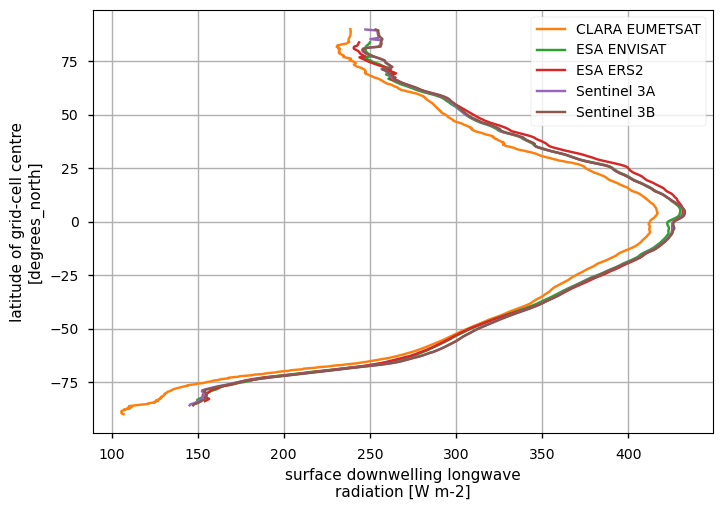

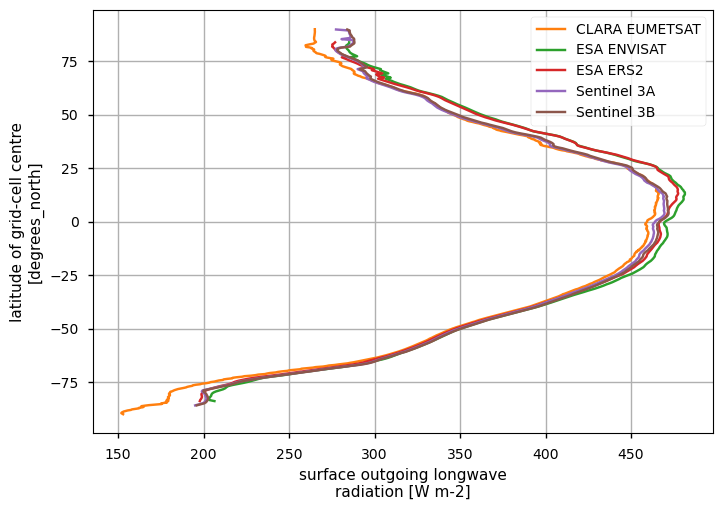

In [5]:
for var in variables:
    for i, (product, ds) in enumerate(ds_maps.items()):
        if var not in ds.data_vars:
            continue
        da = diagnostics.spatial_weighted_mean(ds[var], dim="longitude")
        da.plot(y="latitude", color=f"C{i}", label=product)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

Zonal means exhibit generally similar features, although the different products are poorly consistent in several cases. Incoming shortwave data are inconsisten at high latitude also due to missing data therein, while downwelling longwave radiation significantly differ in the Tropical region.

### Discussion and applications

Evaluation of the surface radiation budget has large implications in climate studies and has been the subject of numerous investigations (e.g., [[8]](https://doi.org/10.5194/acp-5-2847-2005)). We briefly focus on two examples of application, respectively considering the ocean heat uptake and climate model simulation validation. 
The ocean heat uptake refers to the fact that due to the large heat capacity of seawater, most of the excess heat of the Earth's System is stored in the oceans. About 89% of energy is estimated to reside in the global ocean ([[9]](https://doi.org/10.5194/essd-15-1675-2023)); the surface heat budget is responsible for variations in net air-sea heat flux, i.e. the energy flux at the air-sea and ice-sea interface that regulates the temporal variations of the energy accumulated in the oceans. Ocean heat content tendency (or ocean heat uptake) is closely related to the surface radiation budget over the oceans, and any trend in the surface radiation budget will result in acceleration of the ocean warming. SRB observational products ([[5]](https://doi.org/10.3389/fmars.2019.00430)), eventually complemented with model reanalyses or simulations ([[7]](https://doi.org/10.1038/s41467-022-32540-5); [[4]](https://doi.org/10.1175/JCLI-D-21-0793.1)), all contribute to our monitoring and understanding of ocean heat uptake variations.
The second application involves validating climate model simulations in terms of surface radiation budget. For climate predictions and projections, it is important to have a reliable surface radiation budget so that the ocean-atmosphere energy exchanges are accurately simulated. Inaccuracies in the SRB will result, in turn, in biases and systematic errors in the lower atmosphere temperature (e.g., [[6]](https://doi.org/10.1002/2017JD027194)). The SRB products can be used to spot inaccuracies in the climate model simulations, for instance focusing on specific regions, such as polar regions ([[3]](https://doi.org/10.1002/2016JD025099)).

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References


[[1]](https://doi.org/10.1016/j.agrformet.2006.02.001) Yang, K., Koike, T., & Ye, B. (2006). Improving estimation of hourly, daily, and monthly solar radiation by importing global data sets. Agricultural and Forest Meteorology, 137(1-2), 43-55

[[2]](https://doi.org/10.1175/2008BAMS2634.1) Trenberth, K. E., Fasullo, J. T., & Kiehl, J. (2009). Earth's global energy budget. Bulletin of the American Meteorological Society, 90(3), 311-324

[[3]](https://doi.org/10.1002/2016JD025099) Boeke, R. C., and P. C. Taylor (2016), Evaluation of the Arctic surface radiation budget in CMIP5 models, J. Geophys. Res. Atmos., 121, 8525–8548, doi:10.1002/2016JD025099.

[[4]](https://doi.org/10.1175/JCLI-D-21-0793.1) Clément, L., E. L. McDonagh, J. M. Gregory, Q. Wu, A. Marzocchi, J. D. Zika, and A. J. G. Nurser, 2022: Mechanisms of Ocean Heat Uptake along and across Isopycnals. J. Climate, 35, 4885–4904, https://doi.org/10.1175/JCLI-D-21-0793.1.

[[5]](https://doi.org/10.3389/fmars.2019.00430) Cronin MF, Gentemann CL, Edson J, Ueki I, Bourassa M, Brown S, Clayson CA, Fairall CW, Farrar JT, Gille ST, Gulev S, Josey SA, Kato S, Katsumata M, Kent E, Krug M, Minnett PJ, Parfitt R, Pinker RT, Stackhouse PW Jr, Swart S, Tomita H, Vandemark D, Weller RA, Yoneyama K, Yu L and Zhang D (2019) Air-Sea Fluxes With a Focus on Heat and Momentum. Front. Mar. Sci. 6:430. doi:10.3389/fmars.2019.00430

[[6]](https://doi.org/10.1002/2017JD027194) Ma, H.-Y., Klein, S. A., Xie, S., Zhang, C., Tang, S., Tang, Q. et al (2018). CAUSES: On the role of surface energy budget errors to the warm surface air temperature error over the Central United States. Journal of Geophysical Research: Atmospheres, 123, 2888–2909. https://doi.org/10.1002/2017JD027194

[[7]](https://doi.org/10.1038/s41467-022-32540-5) Huguenin, M.F., Holmes, R.M. & England, M.H. Drivers and distribution of global ocean heat uptake over the last half century. Nat Commun 13, 4921 (2022). https://doi.org/10.1038/s41467-022-32540-5

[[8]](https://doi.org/10.5194/acp-5-2847-2005) Hatzianastassiou, N., Matsoukas, C., Fotiadi, A., Pavlakis, K. G., Drakakis, E., Hatzidimitriou, D., and Vardavas, I.: Global distribution of Earth's surface shortwave radiation budget, Atmos. Chem. Phys., 5, 2847–2867, https://doi.org/10.5194/acp-5-2847-2005, 2005.

[[9]](https://doi.org/10.5194/essd-15-1675-2023) von Schuckmann, et al.: Heat stored in the Earth system 1960–2020: where does the energy go?, Earth Syst. Sci. Data, 15, 1675–1709, https://doi.org/10.5194/essd-15-1675-2023, 2023.
